# Regression with Gaussian Processes

------------------------------------------------------
*Machine Learning, Master in Big Data Analytics, 2023-2024*

*Pablo M. Olmos olmos@tsc.uc3m.es, Emilio Parrado Hernandez, eparrado@ing.uc3m.es*

------------------------------------------------------

The aim of this homework is to solve a real data problem using Gaussian Processes.

The problem is the prediction of both the heating load (HL) and cooling load (CL) of residential buildings. We consider eight input variables for each building: relative compactness, surface area, wall area, roof area, overall height, orientation, glazing area, glazing area distribution.

In this [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) you can find a detailed description of the problem and a solution based on linear regression [(iteratively reweighted least squares (IRLS) algorithm)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwjZuoLY2OjgAhUs3uAKHUZ7BVcQFjAJegQIAhAC&url=https%3A%2F%2Fpdfs.semanticscholar.org%2F9b92%2F18e7233f4d0b491e1582c893c9a099470a73.pdf&usg=AOvVaw3YDwqZh1xyF626VqfnCM2k) and random forests. Using GPs, our goal is not only estimate accurately both HL and CL, but also get a measure of uncertainty in our predictions.

The data set can be downloaded from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
from sklearn.linear_model import LinearRegression



## 1. Loading and preparing the data

* Download the dataset
* Divide at random the dataset into train (80%) and test (20%) datasets 

In [2]:

# Suppress all warnings
warnings.filterwarnings("ignore")
# Read the Excel file into a pandas DataFrame
data = pd.read_excel('ENB2012_data.xlsx')

# Define the new column names
new_column_names = {
    'X1': 'Relative Compactness',
    'X2': 'Surface Area',
    'X3': 'Wall Area',
    'X4': 'Roof Area',
    'X5': 'Overall Height',
    'X6': 'Orientation',
    'X7': 'Glazing Area',
    'X8': 'Glazing Area Distribution',
    'Y1': 'Heating Load',
    'Y2': 'Cooling Load'
}

# Rename the columns
data = data.rename(columns=new_column_names)


# Separate features and target variables
X = data.drop(columns=['Heating Load', 'Cooling Load'])
y_heating = data['Heating Load']
y_cooling = data['Cooling Load']

# Split the data into train and test sets
X_train, X_test, y_train_heating, y_test_heating = train_test_split(X, y_heating, test_size=0.2, random_state=42)
X_train, X_test, y_train_cooling, y_test_cooling = train_test_split(X, y_cooling, test_size=0.2, random_state=42)

data

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


## 2. Baseline results: Random Forests (10%)

Train a Random Forests selecting the number of trees in the forest and the maximum number of leaves using cross validation. 

**Print the scores in the test set for each target. These will be our baseline results.** 


In [3]:

# Define preprocessing steps for numerical features
numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Define the Random Forest Regressor pipeline
rf_pipeline_heating = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

rf_pipeline_cooling = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Define hyperparameters to tune
param_grid = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_leaf_nodes': [None, 10, 20, 30]
}

# Perform cross-validation to find the best hyperparameters for heating load
grid_search_heating = RandomizedSearchCV(rf_pipeline_heating, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_heating.fit(X_train, y_train_heating)

# Perform cross-validation to find the best hyperparameters for cooling load
grid_search_cooling = RandomizedSearchCV(rf_pipeline_cooling, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_cooling.fit(X_train, y_train_cooling)

# Get the best estimators
best_rf_heating = grid_search_heating.best_estimator_
best_rf_cooling = grid_search_cooling.best_estimator_

# Fit the models on the training data
best_rf_heating.fit(X_train, y_train_heating)
best_rf_cooling.fit(X_train, y_train_cooling)

# Predict on the test set
y_pred_heating = best_rf_heating.predict(X_test)
y_pred_cooling = best_rf_cooling.predict(X_test)

# Calculate RMSE for each target variable
rmse_heating_RF = root_mean_squared_error(y_test_heating, y_pred_heating)
rmse_cooling_RF = root_mean_squared_error(y_test_cooling, y_pred_cooling)

print("RMSE for Heating Load:", rmse_heating_RF)
print("RMSE for Cooling Load:", rmse_cooling_RF)


RMSE for Heating Load: 0.4921877840877365
RMSE for Cooling Load: 1.7547981774840364


Use attribute `feature_importances_` to discuss which are, for RF, the most informative features to predict each target.

In [4]:
# Get feature importances for heating load prediction
feature_importance_heating = best_rf_heating.named_steps['regressor'].feature_importances_

# Get feature importances for cooling load prediction
feature_importance_cooling = best_rf_cooling.named_steps['regressor'].feature_importances_

# Combine feature importances with feature names
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance for Heating Load': feature_importance_heating,
    'Importance for Cooling Load': feature_importance_cooling
})

# Sort features by importance for each target
feature_importance_df = feature_importance_df.sort_values(by='Importance for Heating Load', ascending=False)
print("Feature importance for Heating Load:")
print(feature_importance_df)

feature_importance_df = feature_importance_df.sort_values(by='Importance for Cooling Load', ascending=False)
print("\nFeature importance for Cooling Load:")
print(feature_importance_df)


Feature importance for Heating Load:
                     Feature  Importance for Heating Load  \
0       Relative Compactness                     0.365086   
1               Surface Area                     0.222077   
3                  Roof Area                     0.191753   
4             Overall Height                     0.095282   
6               Glazing Area                     0.078893   
2                  Wall Area                     0.034243   
7  Glazing Area Distribution                     0.011895   
5                Orientation                     0.000772   

   Importance for Cooling Load  
0                     0.356492  
1                     0.115690  
3                     0.074967  
4                     0.337084  
6                     0.048980  
2                     0.038893  
7                     0.015934  
5                     0.011961  

Feature importance for Cooling Load:
                     Feature  Importance for Heating Load  \
0       Relative 

## 3. First result Gaussian Process (10%)

You will train two independent GPs, one to estimate HL and one to estimate CL. Each of the two GPs will be endowed with a composite kernel function $\kappa_T = \kappa_c \cdot \kappa_r + \kappa_w$, where:
- $\kappa_c$ is a constant kernel
- $\kappa_r$ is an RBF kernel
- $\kappa_w$ is a White Noise kernel

Evaluate those GPs with the corresponding test sets.

**How do these results compare with those obtained using Random Forests?**

**Discuss the contribution of the White Noise kernel and of the constant kernel to the final results**.


In [5]:

# Define composite kernel
def composite_kernel():
    rbf_kernel = RBF()
    white_kernel = WhiteKernel()
    return 1 * rbf_kernel + white_kernel

# Define function to train GP and make predictions
def train_and_predict_gp(X_train, y_train, X_test, kernel):
    gp = GaussianProcessRegressor(kernel=kernel, random_state=42
                                  #, n_restarts_optimizer=10  #añadir al final
                                 )
    gp.fit(X_train, y_train)
    y_pred, sigma = gp.predict(X_test, return_std=True)
    return y_pred, sigma

# Train and predict for Heating Load (HL)
y_pred_heating, sigma_heating = train_and_predict_gp(X_train, y_train_heating.values.reshape(-1, 1), X_test, composite_kernel())
rmse_heating_GP = root_mean_squared_error(y_test_heating, y_pred_heating)

# Train and predict for Cooling Load (CL)
y_pred_cooling, sigma_cooling = train_and_predict_gp(X_train, y_train_cooling.values.reshape(-1, 1), X_test, composite_kernel())
rmse_cooling_GP = root_mean_squared_error(y_test_cooling, y_pred_cooling)

print("RMSE for Heating Load (GP, composite kernel):", rmse_heating_GP)
print("RMSE for Cooling Load (GP, composite kernel):", rmse_cooling_GP)

print("Difference in % with respect to RF (Heating): ", (rmse_heating_GP - rmse_heating_RF)/ 100)
print("Difference in % with respect to RF (Cooling): ", (rmse_cooling_GP - rmse_cooling_RF)/ 100)


RMSE for Heating Load (GP, composite kernel): 0.5014581467097537
RMSE for Cooling Load (GP, composite kernel): 1.7839732059330988
Difference in % with respect to RF (Heating):  9.270362622017247e-05
Difference in % with respect to RF (Cooling):  0.0002917502844906239


In [6]:
## not using the constant kernel

# Train and predict for Heating Load (HL)
y_pred_heating, sigma_heating = train_and_predict_gp(X_train, y_train_heating.values.reshape(-1, 1), X_test, RBF() + WhiteKernel())
rmse_heating = root_mean_squared_error(y_test_heating, y_pred_heating)

# Train and predict for Cooling Load (CL)
y_pred_cooling, sigma_cooling = train_and_predict_gp(X_train, y_train_cooling.values.reshape(-1, 1), X_test,  RBF() + WhiteKernel())
rmse_cooling = root_mean_squared_error(y_test_cooling, y_pred_cooling)

print("RMSE for Heating Load (GP, RBF + white):", rmse_heating)
print("RMSE for Cooling Load (GP, RBF + white):", rmse_cooling)


RMSE for Heating Load (GP, RBF + white): 11.039750612662663
RMSE for Cooling Load (GP, RBF + white): 10.565696317123404


In [7]:
## not using the white kernel
# Train and predict for Heating Load (HL)
y_pred_heating, sigma_heating = train_and_predict_gp(X_train, y_train_heating.values.reshape(-1, 1), X_test, 1 * RBF())
rmse_heating = root_mean_squared_error(y_test_heating, y_pred_heating)

# Train and predict for Cooling Load (CL)
y_pred_cooling, sigma_cooling = train_and_predict_gp(X_train, y_train_cooling.values.reshape(-1, 1), X_test, 1 * RBF())
rmse_cooling = root_mean_squared_error(y_test_cooling, y_pred_cooling)

print("RMSE for Heating Load (GP, RBF * constant):", rmse_heating)
print("RMSE for Cooling Load (GP, RBF * constant):", rmse_cooling)

RMSE for Heating Load (GP, RBF * constant): 25.08541117084569
RMSE for Cooling Load (GP, RBF * constant): 27.0631746609165


In [8]:
## only using RBF
y_pred_heating, sigma_heating = train_and_predict_gp(X_train, y_train_heating.values.reshape(-1, 1), X_test, RBF())
rmse_heating = root_mean_squared_error(y_test_heating, y_pred_heating)

# Train and predict for Cooling Load (CL)
y_pred_cooling, sigma_cooling = train_and_predict_gp(X_train, y_train_cooling.values.reshape(-1, 1), X_test, RBF())
rmse_cooling = root_mean_squared_error(y_test_cooling, y_pred_cooling)

print("RMSE for Heating Load (GP, RBF):", rmse_heating)
print("RMSE for Cooling Load (GP, RBF):", rmse_cooling)


RMSE for Heating Load (GP, RBF): 1.8029858893509365
RMSE for Cooling Load (GP, RBF): 2.77263105971425


After experimenting with various values for the parameters of the Radial Basis Function (RBF) kernel, it was determined that the default parameters yielded the best performance metrics. Therefore, these default parameters were retained for subsequent analyses. 

Utilizing the composite kernel, which combines the RBF, constant, and white noise kernels, the results closely resembled those obtained from the Random Forest baseline, exhibiting less than 0.0001% difference in RMSE between the two approaches.

To discern the individual contributions of the white noise and constant kernels, additional Gaussian Processes (GPs) were fitted without these kernels. The comparison underscored the importance of employing a composite kernel. Specifically, when omitting the constant kernel, the RMSE varied only slightly from the baseline results. However, the exclusion of the white noise kernel led to a significant increase in RMSE, particularly evident in the case of the cooling load, where the RMSE surged to 27, representing a deviation of more than 20 units from the basel e.

In a final analysis, a GP solely utilizing the RBF kernel was tested. While the results were not as adverse as previous attempts, they still fell short of the performance achieved with the complete composite ke

All of this can be explained because when using a composite kernel combining these components, the resulting GP model can capture various aspects of the data, including smooth trends (RBF), global offsets (constant), and noise (white noise). This composite kernel allows the GP to flexibly model complex patterns and uncertainties in the data, resulting in performance comparable to the Random Forest baseline.

However, wheremovingve specific kernel components, such as the white noise kernel, you lose the ability to model certain aspects of the data. In the case of the white noise kernel, removing it can lead to a significant increase in prediction errors, especially when the data contains substantial noise or uncertainty. This is because without the white noise component, the GP may struggle to account for the inherent randomness or variability in the target variable, leading to poorer predictive performanc

In summary, the composite kernel provides a holistic approach to modeling various aspects of the data, leading to comparable performance with the Random Forest baseline.e.vely.


## 4. Gaussian Process with Features selected by Random Forest (10%)

Train now two independent GPs, using the same composite kernel as above, but now with those features indicated by RF as most relevant.

**Is there any significant improvement over RF or GP with all the features?**


In [9]:
# Select most relevant features based on feature importances from Random Forest
selected_features_heating = feature_importance_df.nlargest(5, 'Importance for Heating Load')['Feature'].values
selected_features_cooling = feature_importance_df.nlargest(5, 'Importance for Cooling Load')['Feature'].values

# Filter dataset to include only the selected features
X_train_selected_heating = X_train[selected_features_heating]
X_test_selected_heating = X_test[selected_features_heating]

X_train_selected_cooling = X_train[selected_features_cooling]
X_test_selected_cooling = X_test[selected_features_cooling]


# Train and predict for Heating Load (HL) with selected features
y_pred_heating_selected, sigma_heating_selected = train_and_predict_gp(X_train_selected_heating, y_train_heating.values.reshape(-1, 1), X_test_selected_heating, composite_kernel() )
rmse_heating_selected = root_mean_squared_error(y_test_heating, y_pred_heating_selected)

# Train and predict for Cooling Load (CL) with selected features
y_pred_cooling_selected, sigma_cooling_selected = train_and_predict_gp(X_train_selected_cooling, y_train_cooling.values.reshape(-1, 1), X_test_selected_cooling,  composite_kernel())
rmse_cooling_selected = root_mean_squared_error(y_test_cooling, y_pred_cooling_selected)

print("RMSE for Heating Load (GP with selected features):", rmse_heating_selected)
print("RMSE for Cooling Load (GP with selected features):", rmse_cooling_selected)

print("Difference in % with respect to RF (Heating): ", (rmse_heating_selected - rmse_heating_RF)/ 100)
print("Difference in % with respect to RF (Cooling): ", (rmse_cooling_selected - rmse_cooling_RF)/ 100)

print("Difference in % with respect to GP (Heating): ", (rmse_heating_selected - rmse_heating_GP)/ 100)
print("Difference in % with respect to GP (Cooling): ", (rmse_cooling_selected - rmse_cooling_GP)/ 100)


RMSE for Heating Load (GP with selected features): 0.50168979277141
RMSE for Cooling Load (GP with selected features): 1.7485613106096765
Difference in % with respect to RF (Heating):  9.502008683673513e-05
Difference in % with respect to RF (Cooling):  -6.236866874359981e-05
Difference in % with respect to GP (Heating):  2.3164606165626544e-06
Difference in % with respect to GP (Cooling):  -0.0003541189532342237


It is difficult to determine which are the most important features because we cannot be sure how many do we need. After trying several values, finally we decided that the best results can be obtained by selecting the top 5 features. With that, when performing the GP with the composite kernel we can observe we have quite similar results that previously with RF or GP with all features (selecting less leads to much worst results). However, the RMSE is only improved in the case of ... (terminar de comentar cuando haga el final run porque varían los números).

In general, there are no significant improvements in using the most relevant features only.

## 5. Gaussian Processes with ARD kernels (30%)

Now use and ARD RBF kernel in the composite, that means enable a different lenghtscale for each feature. 

**Discuss the impact of the ARD kernel in the results of the GPs fit for each target.**

**Print the parameters of the kernels after the GPs are fit. In particular discuss how the lengthscale achieved per each feature can be used as a proxy to estimate the relevance of each feature. Are these relevances aligned with those found by Random Forests?**


In [10]:
# Fit the GP models with ARD RBF kernel
kernel_ard = 1.0 * RBF(length_scale=1*np.ones(8), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gp_heating_ard = GaussianProcessRegressor(kernel=kernel_ard, random_state=42)
gp_cooling_ard = GaussianProcessRegressor(kernel=kernel_ard, random_state=42)

gp_heating_ard.fit(X_train, y_train_heating)
gp_cooling_ard.fit(X_train, y_train_cooling)

y_pred_heating= gp_heating_ard.predict(X_test)
y_pred_cooling= gp_cooling_ard.predict(X_test)

# Calculate RMSE
rmse_heating_ARD = root_mean_squared_error(y_test_heating, y_pred_heating)
rmse_cooling_ARD = root_mean_squared_error(y_test_cooling, y_pred_cooling)

#Previous results with usual RBF
print("RMSE for Heating Load (GP, composite kernel with normal RBF):", rmse_heating_GP)
print("RMSE for Cooling Load (GP, composite kernel with normal RBF):", rmse_cooling_GP)

#New results with ARD RBF
print("RMSE for Heating Load (GP, composite kernel with ARD RBF):", rmse_heating_ARD)
print("RMSE for Cooling Load (GP, composite kernel with ARD RBF):", rmse_cooling_ARD)


# Print parameters of the kernels
print("Kernel before fitting:", kernel_ard)
print("Parameters of the ARD RBF kernel for Heating Load:", gp_heating_ard.kernel_)
print("\nParameters of the ARD RBF kernel for Cooling Load:", gp_cooling_ard.kernel_)





RMSE for Heating Load (GP, composite kernel with normal RBF): 0.5014581467097537
RMSE for Cooling Load (GP, composite kernel with normal RBF): 1.7839732059330988
RMSE for Heating Load (GP, composite kernel with ARD RBF): 0.48495202345235755
RMSE for Cooling Load (GP, composite kernel with ARD RBF): 1.7301705932507432
Kernel before fitting: 1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=1)
Parameters of the ARD RBF kernel for Heating Load: 15.9**2 * RBF(length_scale=[1, 1, 1, 1, 1, 100, 0.234, 100]) + WhiteKernel(noise_level=0.189)

Parameters of the ARD RBF kernel for Cooling Load: 18.2**2 * RBF(length_scale=[1, 1, 1, 1, 1, 100, 1.09, 100]) + WhiteKernel(noise_level=2.7)


In [11]:
# We remember the order of the columns to deduce which length scale correspond to which variable
X_test.columns

Index(['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
       'Overall Height', 'Orientation', 'Glazing Area',
       'Glazing Area Distribution'],
      dtype='object')

In [12]:
# We remember the selected features from the RF
print(selected_features_heating)
print(selected_features_cooling)

['Relative Compactness' 'Surface Area' 'Roof Area' 'Overall Height'
 'Glazing Area']
['Relative Compactness' 'Overall Height' 'Surface Area' 'Roof Area'
 'Glazing Area']


Firstly, we can observe that for both Heating Load and Cooling Load, using the ARD RBF kernel leads to slight improvements in RMSE compared to the composite kernel with normal RBF. This suggests that the ARD kernel, which allows for different length scales for each feature, captures the underlying patterns in the data more effectively.

Secondly, regarding the length scales, they represent the characteristic length of each feature, indicating how much influence each feature has on the predictions. A smaller length scale implies that the corresponding feature has more relevance in predicting the target variable. Therefore, for both heating load and cooling load, we observe how the first 5 have in general the smallest length scales (in order, Relative Compactness, Surface Area, Wall Area, Roof Area and Overall Heigth). However, its important to notice than for the Heating Load the Glazing Area variable has a smaller value, indicating that it strongly influences the Heating Load predictions as well.

Having this in mind, if we remember the RF most frequent features, printed above, we can observe some alignment. Except for the Wall Area selected on the Gaussian Process, the rest are the same. Features with shorter length scales in the ARD kernel are generally expected to align with features identified as important by Random Forests. However, the absolute values of importance might differ due to the different nature of the models and their underlying assumptions.

Overall, the use of the ARD RBF kernel allows for more flexible modeling by capturing varying importance of features, leading to improved performance in predicting both Heating Load and Cooling Load compared to the composite kernel with a normal RBF.

**Discuss the impact of scaling or not the data in the conclusions extracted from the ARD results.** 

In [13]:

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the GP models with ARD RBF kernel
kernel_ard = 1.0 * RBF(length_scale=1*np.ones(8), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gp_heating_ard_scaled = GaussianProcessRegressor(kernel=kernel_ard, random_state=42)
gp_cooling_ard_scaled = GaussianProcessRegressor(kernel=kernel_ard, random_state=42)

gp_heating_ard_scaled.fit(X_train_scaled, y_train_heating)
gp_cooling_ard_scaled.fit(X_train_scaled, y_train_cooling)

# Predict using the fitted models
y_pred_heating = gp_heating_ard_scaled.predict(X_test_scaled)
y_pred_cooling = gp_cooling_ard_scaled.predict(X_test_scaled)

# Calculate RMSE
rmse_heating_ARD_scaled = root_mean_squared_error(y_test_heating, y_pred_heating)
rmse_cooling_ARD_scaled = root_mean_squared_error(y_test_cooling, y_pred_cooling)

#New results with ARD RBF
print("RMSE for Heating Load (GP, composite kernel with ARD RBF, non-scaled data):", rmse_heating_ARD)
print("RMSE for Cooling Load (GP, composite kernel with ARD RBF, non-scaled data):", rmse_cooling_ARD)


print("RMSE for Heating Load (GP, composite kernel with ARD RBF, scaled data):", rmse_heating_ARD_scaled)
print("RMSE for Cooling Load (GP, composite kernel with ARD RBF, scaled data):", rmse_cooling_ARD_scaled)

# Print parameters of the kernels
print("Parameters of the ARD RBF kernel for Heating Load (non-scaled data):", gp_heating_ard.kernel_)
print("\nParameters of the ARD RBF kernel for Cooling Load (non-scaled data):", gp_cooling_ard.kernel_)

print("Parameters of the ARD RBF kernel for Heating Load (scaled data):", gp_heating_ard_scaled.kernel_)
print("\nParameters of the ARD RBF kernel for Cooling Load (scaled data):", gp_cooling_ard_scaled.kernel_)


RMSE for Heating Load (GP, composite kernel with ARD RBF, non-scaled data): 0.48495202345235755
RMSE for Cooling Load (GP, composite kernel with ARD RBF, non-scaled data): 1.7301705932507432
RMSE for Heating Load (GP, composite kernel with ARD RBF, scaled data): 0.49036084050424195
RMSE for Cooling Load (GP, composite kernel with ARD RBF, scaled data): 1.7205519185822173
Parameters of the ARD RBF kernel for Heating Load (non-scaled data): 15.9**2 * RBF(length_scale=[1, 1, 1, 1, 1, 100, 0.234, 100]) + WhiteKernel(noise_level=0.189)

Parameters of the ARD RBF kernel for Cooling Load (non-scaled data): 18.2**2 * RBF(length_scale=[1, 1, 1, 1, 1, 100, 1.09, 100]) + WhiteKernel(noise_level=2.7)
Parameters of the ARD RBF kernel for Heating Load (scaled data): 19.1**2 * RBF(length_scale=[0.871, 1.09, 2.32, 100, 100, 100, 2.28, 100]) + WhiteKernel(noise_level=0.193)

Parameters of the ARD RBF kernel for Cooling Load (scaled data): 17.8**2 * RBF(length_scale=[1.2, 0.604, 2.25, 100, 0.411, 100, 8

Comparing the RMSE values, we observe minor differences between non-scaled and scaled data for both Heating Load and Cooling Load predictions. In general, scaling the data slightly improves the RMSE for Heating Load while having negligible impact on Cooling Load predictions.

However, scaling the data affects the range of length scales obtained for each feature. In non-scaled data, the length scales span a wider range, while in scaled data, the length scales are more homogeneous and closer in magnitude. This indicates that scaling the data helps standardize the influence of features on predictions.

Then, scaling the data is beneficial for Gaussian Processes, especially when features have different scales or magnitudes. Scaling ensures that all features contribute equally to the model and prevents features with larger scales from dominating the predictions. 
In this case, although the differences in RMSE between non-scaled and scaled data are minor, scaling still provides more consistent and interpretable results by standardizing the feature magnitudes. Additionally, scaling helps stabilize the optimization process and improves convergence.

## 6. Predictive distributions (15%)

The predictive distribution can be employed to asses the confidence on the predictions made by the GPs. For the GPs fit in parts 3 (composite kernel, single RBF lengthscale for all features) and 5 (ARD kernel) compute the predictions for the test data including mean and standard deviation.

**For each GP produce an scatter plot of the absolute error of the predictions (true target minus mean of the predictive distributions) vs. the standard deviation of the corresponding predictive distribution. Is the standard deviation of the predictive distribution informative about the confidence in the predictions?**

In [14]:
# Train and predict for Heating Load (HL) single RBF
y_pred_heating, sigma_heating = train_and_predict_gp(X_train_scaled, y_train_heating.values.reshape(-1, 1), X_test_scaled, composite_kernel())

# Train and predict for Cooling Load (CL) single RBF
y_pred_cooling, sigma_cooling = train_and_predict_gp(X_train_scaled, y_train_cooling.values.reshape(-1, 1), X_test_scaled, composite_kernel())

kernel_ard = 1.0 * RBF(length_scale=1*np.ones(8), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()

# Train and predict for Heating Load (HL) ARD RBF
y_pred_heating_ARD, sigma_heating_ARD = train_and_predict_gp(X_train_scaled, y_train_heating.values.reshape(-1, 1), X_test_scaled, kernel_ard)

# Train and predict for Cooling Load (CL) ARD RBF
y_pred_cooling_ARD, sigma_cooling_ARD = train_and_predict_gp(X_train_scaled, y_train_cooling.values.reshape(-1, 1), X_test_scaled, kernel_ard)


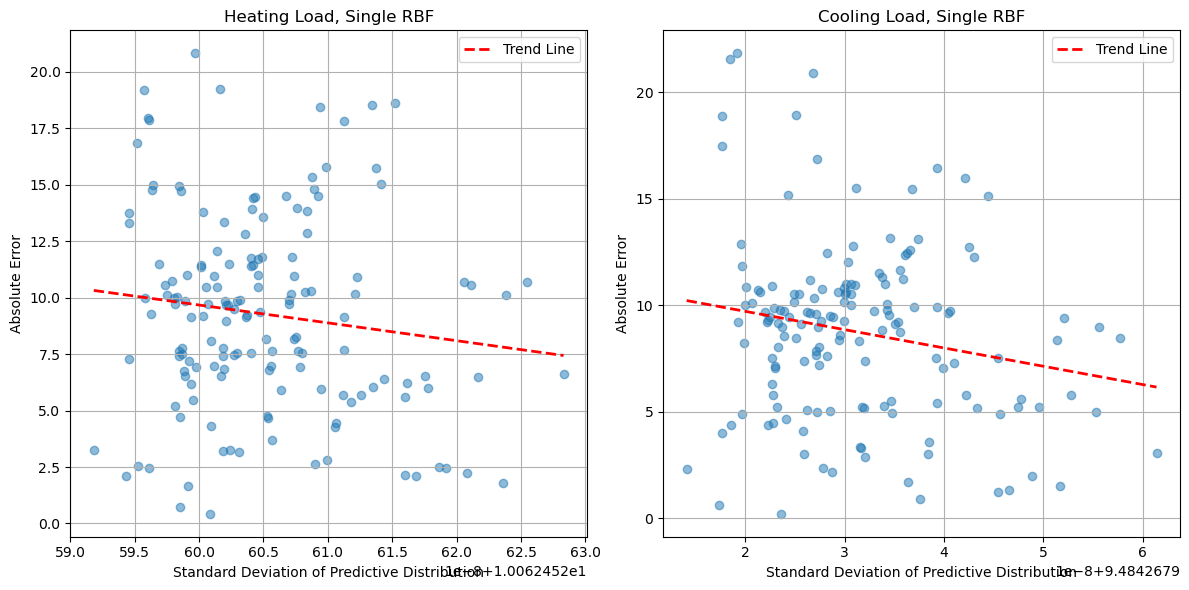

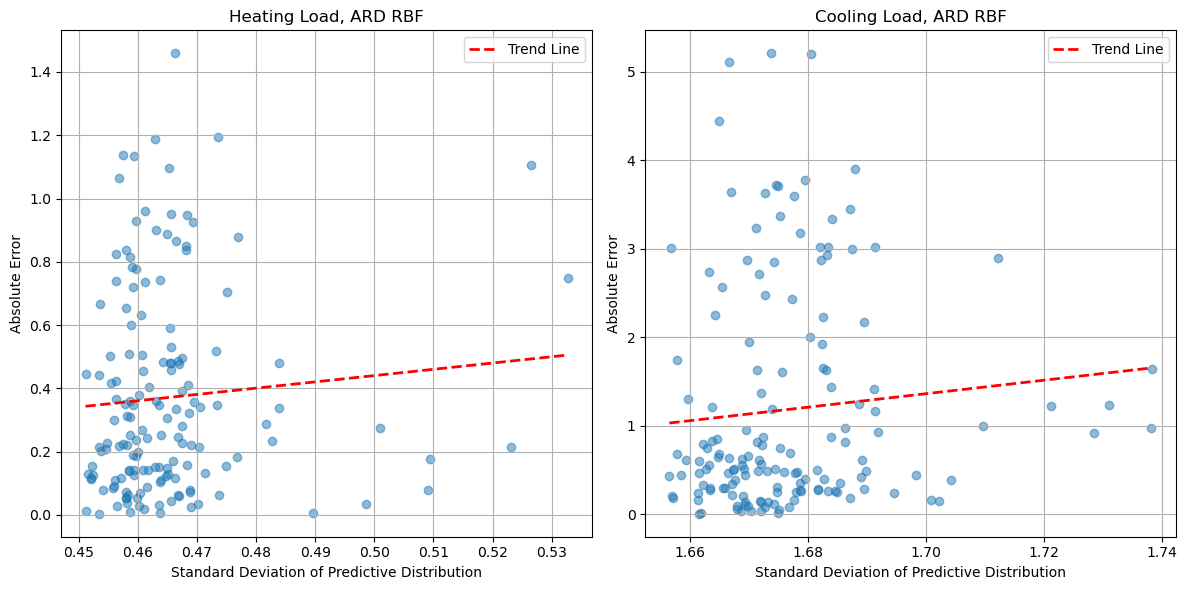

In [16]:

# Function to plot scatter plot with trend line
def scatter_with_trend(sigma, abs_error, title):
    plt.scatter(sigma, abs_error, alpha=0.5)
    plt.xlabel('Standard Deviation of Predictive Distribution')
    plt.ylabel('Absolute Error')
    plt.title(title)
    plt.grid(True)
    
    # Fit linear regression
    lr = LinearRegression()
    lr.fit(sigma.reshape(-1, 1), abs_error)
    trend_x = np.linspace(min(sigma), max(sigma), 100)
    trend_y = lr.predict(trend_x.reshape(-1, 1))
    
    # Plot trend line
    plt.plot(trend_x, trend_y, color='red', linestyle='--', linewidth=2, label='Trend Line')
    plt.legend()

# Calculate absolute errors
abs_error_heating = np.abs(y_test_heating - y_pred_heating)
abs_error_cooling = np.abs(y_test_cooling - y_pred_cooling)
abs_error_heating_ARD = np.abs(y_test_heating - y_pred_heating_ARD)
abs_error_cooling_ARD = np.abs(y_test_cooling - y_pred_cooling_ARD)

# Create scatter plots
plt.figure(figsize=(12, 6))

# Scatter plot for Heating Load, single RBF
plt.subplot(1, 2, 1)
scatter_with_trend(sigma_heating, abs_error_heating, 'Heating Load, Single RBF')

# Scatter plot for Cooling Load, single RBF
plt.subplot(1, 2, 2)
scatter_with_trend(sigma_cooling, abs_error_cooling, 'Cooling Load, Single RBF')

plt.tight_layout()
plt.show()

# Create scatter plots for ARD kernels
plt.figure(figsize=(12, 6))

# Scatter plot for Heating Load, ARD RBF
plt.subplot(1, 2, 1)
scatter_with_trend(sigma_heating_ARD, abs_error_heating_ARD, 'Heating Load, ARD RBF')

# Scatter plot for Cooling Load, ARD RBF
plt.subplot(1, 2, 2)
scatter_with_trend(sigma_cooling_ARD, abs_error_cooling_ARD, 'Cooling Load, ARD RBF')

plt.tight_layout()
plt.show()


First, this experiment was conducted using scaled data, as demonstrated to yield better results in earlier analyses. The objective of these scatter plots was to assess whether the standard deviation of the predictive distribution could serve as an indicator of confidence in the predictions. Ideally, one would expect to observe a trend where higher standard deviations correspond to higher absolute errors, reflecting lower confidence in those predictions. However, such a clear trend is not evident in either the single RBF or ARD RBF kernels.

In the case of the single RBF kernel, the scatter plot depicts a dense cluster of points, and even when attempting to discern a trend within this cloud, the opposite relationship is observed: higher standard deviations tend to correspond to lower absolute errors, contrary to our expectations.

For the ARD RBF kernel, a positive trend is discernible, indicating that higher standard deviations are associated with higher absolute errors. However, the slope of this trend is notably small, suggesting that the relationship is not particularly strong.

In summary, while the ARD RBF kernel exhibits a modestly positive relationship between standard deviation and absolute error, neither kernel demonstrates a clear and strong relationship between these metrics. This implies that the standard deviation of the predictive distribution may not be a reliable indicator of confidence in the predictions when using these specific kernels and dataset configurations. Further investigation and experimentation may be warranted to explore alternative approaches for assessing prediction confidence in Gaussian Process models.

## 7. Advanced kernels (25%)

Finally we will try to improve the results by using a more complicated kernel, which combine various covariance functions. Try to evaluate at least 10 different composite kernels by combining different instances of the basic kernels presented in class. Consider doing this programatically.

**Discuss about how the diversity of the results in each target as you vary the composite kernels configuration.**

In [17]:

# Define different kernel combinations
kernels = [RBF(length_scale=1.0) + WhiteKernel(), # single RBF + white
    RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(), # ARD RBF + white
    1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(), # 1 * ARD RBF + white
    1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel() + DotProduct(), # 1 * ARD RBF + white + Dotproduct
    1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel() + DotProduct() + 3,
    1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel() + DotProduct() * 1,
    2 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel() + DotProduct(sigma_0=2),
    2 * RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel() + DotProduct(sigma_0=2),
    0.1 * RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel() + DotProduct(sigma_0=3),
    1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel() + DotProduct(sigma_0=2)

]

# Loop over each kernel combination
for i, composite_kernel in enumerate(kernels):
    # Initialize Gaussian Process regressors
    gp_heating = GaussianProcessRegressor(kernel=composite_kernel, random_state=42)
    gp_cooling = GaussianProcessRegressor(kernel=composite_kernel, random_state=42)

    # Fit the models
    gp_heating.fit(X_train_scaled, y_train_heating)
    gp_cooling.fit(X_train_scaled, y_train_cooling)

    # Predict using the fitted models
    y_pred_heating = gp_heating.predict(X_test_scaled)
    y_pred_cooling = gp_cooling.predict(X_test_scaled)

    # Calculate RMSE
    rmse_heating = root_mean_squared_error(y_test_heating, y_pred_heating)
    rmse_cooling = root_mean_squared_error(y_test_cooling, y_pred_cooling)

    # Print results
    print(f"\nKernel combination {i+1}:")
    print("RMSE for Heating Load :", rmse_heating)
    print("RMSE for Cooling Load :", rmse_cooling)
    print("Kernel before fitting:", composite_kernel)
    print("Parameters of the composite kernel for Heating Load:", gp_heating.kernel_)
    print("Parameters of the composite kernel for Cooling Load:", gp_cooling.kernel_)



Kernel combination 1:
RMSE for Heating Load : 11.039782521813912
RMSE for Cooling Load : 10.565732071084634
Kernel before fitting: RBF(length_scale=1) + WhiteKernel(noise_level=1)
Parameters of the composite kernel for Heating Load: RBF(length_scale=1e+05) + WhiteKernel(noise_level=113)
Parameters of the composite kernel for Cooling Load: RBF(length_scale=1e+05) + WhiteKernel(noise_level=102)

Kernel combination 2:
RMSE for Heating Load : 3.5706355030067094
RMSE for Cooling Load : 4.20875822448175
Kernel before fitting: RBF(length_scale=1) + WhiteKernel(noise_level=1)
Parameters of the composite kernel for Heating Load: RBF(length_scale=4.06) + WhiteKernel(noise_level=11.3)
Parameters of the composite kernel for Cooling Load: RBF(length_scale=4.51) + WhiteKernel(noise_level=16.2)

Kernel combination 3:
RMSE for Heating Load : 0.47207876675398175
RMSE for Cooling Load : 1.344313647304974
Kernel before fitting: 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)
Parameters of the co